In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

## DAY 1: Generate the sp 500 datatable and create a sql dataset which updates daily at 2:00 AM

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-5-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

[*********************100%%**********************]  503 of 503 completed


In [3]:
df.head(1000)

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-27 A        42.996677   45.820000   45.849998   45.369999   45.549999   
           AAL      30.416389   31.650000   31.840000   31.410000   31.600000   
           AAPL     23.042532   25.087500   25.117500   24.812500   24.860001   
           ABBV     44.441605   62.709999   63.200001   61.900002   61.990002   
           ABT      33.919987   39.299999   39.400002   38.919998   39.040001   
...                       ...         ...         ...         ...         ...   
2016-06-01 AOS      36.213184   41.244999   41.294998   40.775002   41.150002   
           APA      47.557526   56.169998   56.860001   55.180000   56.490002   
           APD     109.782028  133.209991  133.358002  130.666046  131.507858   
           APH      27.207458   29.405001   29.459999   29.165001   29.219999   
           APTV     54.005341   56.211231   56.487846   55.222130   56.345348   

Price                   volume  
date       ticker               
2016-05-27 A         1822700.0  
           AAL       8573700.0  
           AAPL    145364800.0  
           ABBV      5768000.0  
           ABT      12339400.0  
...                        ...  
2016-06-01 AOS       1668400.0  
           APA       3818400.0  
           APD        887609.0  
           APH       2323400.0  
           APTV      2476429.0  

[1000 rows x 6 columns]

## Feature Engineering & Learning

### RSI, GKV, BB do not require standardization

## Interpretation of RSI
### RSI > 70: The asset is generally considered overbought and may be due for a price correction or pullback.
### RSI < 30: The asset is generally considered oversold and may be due for a price rebound or rally.
### RSI between 30 and 70: The asset is considered to be in a neutral range.

In [4]:
### grouby(level=1)here is grouped by price ticker

In [5]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

## Garman-Klass Volatility

### Garman-Klass volatility is a valuable feature in financial analysis and modeling due to its comprehensive approach to measuring daily volatility. By incorporating high, low, open, and close prices, it provides a more accurate and reliable estimate of volatility, which can improve risk management, trading strategies, and predictive models. Integrating GK volatility into your financial workflows can enhance the robustness and accuracy of your analysis and decision-making processes.

In [6]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

## Bollinger Bands
### Bollinger Bands are a type of statistical chart characterizing the prices and volatility over time of a financial instrument or commodity. They were developed by John Bollinger in the 1980s and are widely used in technical analysis to identify overbought or oversold conditions and to predict potential market reversals.



In [7]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

## ATRAverage True Range (ATR):

### The ATR is the moving average of the true range over a specified period, usually 14 days.


In [8]:
## transform works with only one column

In [9]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std()) ## standardize atr

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


## Moving Average Convergence Divergence (MACD) indicator, the two moving averages referred to are:

### Short-term Exponential Moving Average (EMA):

This is typically the 12-period EMA, which reacts more quickly to recent price changes due to its shorter period.
It represents the short-term trend and highlights recent price movements more clearly.

### Long-term Exponential Moving Average (EMA):

This is usually the 26-period EMA, which reacts more slowly to price changes because it averages over a longer period.
It represents the long-term trend and smooths out more of the daily price fluctuations.

In [10]:
## iloc returns the first column, which is the MACD column,and this is because the package generates a dataframe

## Read the MACD Score
## Typical Value Ranges:

### -1 to 1: Most of the values (approximately 68% of data in a normal distribution) fall within one standard deviation of the mean. This range can be considered as the normal fluctuation around the mean.
### -2 to 2: Approximately 95% of the data in a normal distribution falls within two standard deviations of the mean. Values in this range are more significant but still within expected limits.
### Beyond -2 or 2: Values beyond two standard deviations from the mean are relatively rare (approximately 5% of the data in a normal distribution). These values indicate unusually strong movements and can be interpreted as strong bullish or bearish signals depending on the direction.

In [11]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)


## Dollar Volume

In [12]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

In [13]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-27 A        42.996677   45.820000   45.849998   45.369999   45.549999   
           AAL      30.416389   31.650000   31.840000   31.410000   31.600000   
           AAPL     23.042532   25.087500   25.117500   24.812500   24.860001   
           ABBV     44.441605   62.709999   63.200001   61.900002   61.990002   
           ABT      33.919987   39.299999   39.400002   38.919998   39.040001   
...                       ...         ...         ...         ...         ...   
2024-05-24 XYL     143.873550  144.250000  145.089996  143.020004  144.779999   
           YUM     137.649994  137.649994  137.979996  136.690002  136.889999   
           ZBH     116.410004  116.410004  116.529999  115.440002  116.019997   
           ZBRA    327.000000  327.000000  327.000000  322.600006  325.309998   
           ZTS     170.070007  170.070007  172.270004  169.729996  171.570007   

Price                   volume        rsi  garman_klass_vol    bb_low  \
date       ticker                                                       
2016-05-27 A         1822700.0        NaN         -0.001230       NaN   
           AAL       8573700.0        NaN         -0.000471       NaN   
           AAPL    145364800.0        NaN         -0.002152       NaN   
           ABBV      5768000.0        NaN         -0.042568       NaN   
           ABT      12339400.0        NaN         -0.007559       NaN   
...                        ...        ...               ...       ...   
2024-05-24 XYL       1477100.0  68.324304          0.000088  4.883505   
           YUM       1453200.0  50.569502          0.000032  4.896600   
           ZBH       1084200.0  38.190232          0.000040  4.768804   
           ZBRA       205400.0  63.851556          0.000081  5.723580   
           ZTS       1893800.0  53.373278          0.000081  5.075264   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-05-27 A            NaN       NaN       NaN       NaN      78.370044  
           AAL          NaN       NaN       NaN       NaN     260.780998  
           AAPL         NaN       NaN       NaN       NaN    3349.573051  
           ABBV         NaN       NaN       NaN       NaN     256.339175  
           ABT          NaN       NaN       NaN       NaN     418.552284  
...                     ...       ...       ...       ...            ...  
2024-05-24 XYL     4.949697  5.015889  0.315464  2.001636     212.515621  
           YUM     4.930458  4.964316  0.423962 -0.072034     200.032971  
           ZBH     4.795228  4.821653 -0.741663 -0.619564     126.211726  
           ZBRA    5.763489  5.803398 -0.192162  0.925236      67.165800  
           ZTS     5.131359  5.187453  0.659626  0.943332     322.078580  

[992494 rows x 14 columns]

## Monthly Level

In [14]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2016-05-31 A           87.767988
           AAL        277.875248
           AAPL      3614.996196
           ABBV       287.558877
           ABT        480.982120
...                          ...
2024-05-31 XYL        188.731734
           YUM        271.015233
           ZBH        157.543626
           ZBRA        98.104742
           ZTS        440.301822

[47846 rows x 1 columns]

In [15]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]


In [16]:
df.unstack()[last_cols].resample('M').last().stack('ticker')

Price               adj close        rsi  garman_klass_vol    bb_low  \
date       ticker                                                      
2016-05-31 A        43.062370        NaN         -0.001415       NaN   
           AAL      30.666254        NaN         -0.000261       NaN   
           AAPL     22.930017        NaN         -0.002498       NaN   
           ABBV     44.597515        NaN         -0.044786       NaN   
           ABT      34.204819        NaN         -0.007440       NaN   
...                       ...        ...               ...       ...   
2024-05-31 XYL     143.873550  68.324304          0.000088  4.883505   
           YUM     137.649994  50.569502          0.000032  4.896600   
           ZBH     116.410004  38.190232          0.000040  4.768804   
           ZBRA    327.000000  63.851556          0.000081  5.723580   
           ZTS     170.070007  53.373278          0.000081  5.075264   

Price                bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-05-31 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-05-31 XYL     4.949697  5.015889  0.315464  2.001636  
           YUM     4.930458  4.964316  0.423962 -0.072034  
           ZBH     4.795228  4.821653 -0.741663 -0.619564  
           ZBRA    5.763489  5.803398 -0.192162  0.925236  
           ZTS     5.131359  5.187453  0.659626  0.943332  

[47846 rows x 8 columns]

In [17]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                         df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1)).dropna()
data

dollar_volume   adj close        rsi  garman_klass_vol  \
date       ticker                                                           
2016-07-31 A           75.466178   45.264515  63.954581         -0.000743   
           AAL        401.105354   34.116325  59.638233         -0.000845   
           AAPL      3118.136258   23.928869  66.365651         -0.002745   
           ABBV       350.139803   47.348202  66.422385         -0.039624   
           ABT        403.487975   38.861828  76.686201         -0.006625   
...                          ...         ...        ...               ...   
2024-05-31 XYL        188.731734  143.873550  68.324304          0.000088   
           YUM        271.015233  137.649994  50.569502          0.000032   
           ZBH        157.543626  116.410004  38.190232          0.000040   
           ZBRA        98.104742  327.000000  63.851556          0.000081   
           ZTS        440.301822  170.070007  53.373278          0.000081   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-07-31 A       3.746726  3.795039  3.843352 -1.318861  0.089020  
           AAL     3.334677  3.509816  3.684955  0.633478  1.764621  
           AAPL    3.110997  3.162217  3.213437 -1.213716 -0.118666  
           ABBV    3.809448  3.841618  3.873788 -1.323269  0.131533  
           ABT     3.562258  3.628716  3.695173 -1.215132  0.735724  
...                     ...       ...       ...       ...       ...  
2024-05-31 XYL     4.883505  4.949697  5.015889  0.315464  2.001636  
           YUM     4.896600  4.930458  4.964316  0.423962 -0.072034  
           ZBH     4.768804  4.795228  4.821653 -0.741663 -0.619564  
           ZBRA    5.723580  5.763489  5.803398 -0.192162  0.925236  
           ZTS     5.075264  5.131359  5.187453  0.659626  0.943332  

[46861 rows x 9 columns]

In [18]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data

dollar_volume   adj close        rsi  garman_klass_vol  \
date       ticker                                                           
2016-07-31 A                 NaN   45.264515  63.954581         -0.000743   
           AAL               NaN   34.116325  59.638233         -0.000845   
           AAPL              NaN   23.928869  66.365651         -0.002745   
           ABBV              NaN   47.348202  66.422385         -0.039624   
           ABT               NaN   38.861828  76.686201         -0.006625   
...                          ...         ...        ...               ...   
2024-05-31 XYL        110.891843  143.873550  68.324304          0.000088   
           YUM        194.425889  137.649994  50.569502          0.000032   
           ZBH        175.713249  116.410004  38.190232          0.000040   
           ZBRA       124.810171  327.000000  63.851556          0.000081   
           ZTS        329.157351  170.070007  53.373278          0.000081   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-07-31 A       3.746726  3.795039  3.843352 -1.318861  0.089020  
           AAL     3.334677  3.509816  3.684955  0.633478  1.764621  
           AAPL    3.110997  3.162217  3.213437 -1.213716 -0.118666  
           ABBV    3.809448  3.841618  3.873788 -1.323269  0.131533  
           ABT     3.562258  3.628716  3.695173 -1.215132  0.735724  
...                     ...       ...       ...       ...       ...  
2024-05-31 XYL     4.883505  4.949697  5.015889  0.315464  2.001636  
           YUM     4.896600  4.930458  4.964316  0.423962 -0.072034  
           ZBH     4.768804  4.795228  4.821653 -0.741663 -0.619564  
           ZBRA    5.723580  5.763489  5.803398 -0.192162  0.925236  
           ZTS     5.075264  5.131359  5.187453  0.659626  0.943332  

[46861 rows x 9 columns]

In [19]:
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close        rsi  garman_klass_vol    bb_low  \
date       ticker                                                      
2017-06-30 AAL      48.838982  59.919050         -0.000020  3.858655   
           AAPL     33.703407  43.606726         -0.001808  3.515703   
           ABBV     53.369362  71.505778         -0.036447  3.924985   
           ABT      43.018211  67.057183         -0.006063  3.734658   
           ACN     111.341942  49.971709         -0.003969  4.703720   
...                       ...        ...               ...       ...   
2024-05-31 VZ       39.740002  48.879154          0.000005  3.683193   
           WFC      60.209999  54.402499          0.000034  4.088323   
           WMT      65.379997  70.700012          0.000048  4.059648   
           XOM     113.419998  43.192364          0.000100  4.737796   
           ZTS     170.070007  53.373278          0.000081  5.075264   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-06-30 AAL     3.891033  3.923412  0.508506  0.708565  
           AAPL    3.567603  3.619503 -1.081656 -0.449877  
           ABBV    3.972575  4.020166 -1.525846  0.403945  
           ABT     3.772220  3.809783 -1.328072  0.466946  
           ACN     4.735047  4.766373 -1.092398 -0.202202  
...                     ...       ...       ...       ...  
2024-05-31 VZ      3.707919  3.732646 -0.837714 -0.092973  
           WFC     4.119828  4.151333 -0.205359  0.577351  
           WMT     4.135708  4.211769  1.278602  2.671543  
           XOM     4.767122  4.796448  0.661316 -0.382638  
           ZTS     5.131359  5.187453  0.659626  0.943332  

[12516 rows x 8 columns]

In [20]:
### df.xs is a powerful method for extracting specific cross-sections of data from MultiIndex DataFrames

## Monthly Returns

In [21]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close        rsi  garman_klass_vol    bb_low  \
date       ticker                                                      
2018-06-30 AAL      37.156170  30.484789         -0.000030  3.636104   
           AAPL     43.992630  49.582360         -0.000987  3.786773   
           ABBV     70.505760  38.080561         -0.029046  4.251017   
           ABT      55.062870  47.018495         -0.004588  4.017404   
           ACN     150.009140  58.053502         -0.003033  4.970734   
...                       ...        ...               ...       ...   
2024-05-31 VRTX    456.950012  74.371373          0.000117  5.957095   
           VZ       39.740002  48.879154          0.000005  3.683193   
           WFC      60.209999  54.402499          0.000034  4.088323   
           WMT      65.379997  70.700012          0.000048  4.059648   
           XOM     113.419998  43.192364          0.000100  4.737796   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-06-30 AAL     3.737324  3.838545  0.675041 -1.726075  -0.128158   
           AAPL    3.824281  3.861789 -1.021954 -0.315160  -0.009418   
           ABBV    4.313625  4.376234 -0.280046 -1.216535  -0.063574   
           ABT     4.047169  4.076934 -0.957219 -0.327912  -0.008776   
           ACN     5.002521  5.034309 -0.629403  0.030994   0.050405   
...                     ...       ...       ...       ...        ...   
2024-05-31 VRTX    6.052222  6.147349  1.042072  2.841439   0.163285   
           VZ      3.707919  3.732646 -0.837714 -0.092973   0.006331   
           WFC     4.119828  4.151333 -0.205359  0.577351   0.020839   
           WMT     4.135708  4.211769  1.278602  2.671543   0.105414   
           XOM     4.767122  4.796448  0.661316 -0.382638  -0.033218   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-06-30 AAL     -0.058566  -0.098656  -0.050518  -0.023882   -0.022526  
           AAPL     0.060393   0.034635   0.016401   0.021872    0.022450  
           ABBV    -0.020405  -0.003677  -0.004230   0.007379    0.023476  
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784  
           ACN      0.040166   0.024443   0.012599   0.023607    0.025152  
...                      ...        ...        ...        ...         ...  
2024-05-31 VRTX     0.045541   0.027902   0.043067   0.030614    0.029181  
           VZ      -0.018965   0.003019   0.011552   0.020370    0.015182  
           WFC      0.022151   0.028933   0.053562   0.045310    0.037617  
           WMT      0.044198   0.039482   0.041075   0.022248    0.024798  
           XOM     -0.008201   0.030389   0.019562   0.005158    0.011648  

[10369 rows x 14 columns]

## Fama French Factor

In [22]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050405
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[10227 rows x 6 columns]

In [23]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050405
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[10188 rows x 6 columns]

In [24]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-06-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-04-30 VRTX    0.366069  0.640066 -0.678316  0.325818  0.739600
           VZ      0.445599 -1.036031  0.572286  0.109182 -0.072941
           WFC     1.099293  0.259486  1.225702 -0.520459 -0.781069
           WMT     0.609517  0.128332 -0.665666  0.617154  0.467726
           XOM     0.792478 -0.105618  0.684626  0.877219  0.323782

[10188 rows x 5 columns]

In [25]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10198 entries, (Timestamp('2018-06-30 00:00:00'), 'AAL') to (Timestamp('2024-05-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rsi               10198 non-null  float64
 1   garman_klass_vol  10198 non-null  float64
 2   bb_low            10198 non-null  float64
 3   bb_mid            10198 non-null  float64
 4   bb_high           10198 non-null  float64
 5   atr               10198 non-null  float64
 6   macd              10198 non-null  float64
 7   return_1m         10198 non-null  float64
 8   return_2m         10198 non-null  float64
 9   return_3m         10198 non-null  float64
 10  return_6m         10198 non-null  float64
 11  return_9m         10198 non-null  float64
 12  return_12m        10198 non-null  float64
 13  Mkt-RF            10198 non-null  float64
 14  SMB               10198 non-null  float64
 15  HML        

## K Mean

In [26]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 0] = target_rsi_values

initial_centroids

array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

### If the initialization of the cluster is random, when we produce the plots, the cluster colors and labels will be all over the places, however, we want to classify the rsi over 70 into one cluster therefore we define them/

In [31]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

rsi  garman_klass_vol    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-06-30 AAL     30.484789         -0.000030  3.636104  3.737324  3.838545   
           AAPL    49.582360         -0.000987  3.786773  3.824281  3.861789   
           ABBV    38.080561         -0.029046  4.251017  4.313625  4.376234   
           ABT     47.018495         -0.004588  4.017404  4.047169  4.076934   
           ACN     58.053502         -0.003033  4.970734  5.002521  5.034309   
...                      ...               ...       ...       ...       ...   
2024-05-31 VRTX    74.371373          0.000117  5.957095  6.052222  6.147349   
           VZ      48.879154          0.000005  3.683193  3.707919  3.732646   
           WFC     54.402499          0.000034  4.088323  4.119828  4.151333   
           WMT     70.700012          0.000048  4.059648  4.135708  4.211769   
           XOM     43.192364          0.000100  4.737796  4.767122  4.796448   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-06-30 AAL     0.675041 -1.726075  -0.128158  -0.058566  -0.098656   
           AAPL   -1.021954 -0.315160  -0.009418   0.060393   0.034635   
           ABBV   -0.280046 -1.216535  -0.063574  -0.020405  -0.003677   
           ABT    -0.957219 -0.327912  -0.008776   0.024305   0.007529   
           ACN    -0.629403  0.030994   0.050405   0.040166   0.024443   
...                     ...       ...        ...        ...        ...   
2024-05-31 VRTX    1.042072  2.841439   0.163285   0.045541   0.027902   
           VZ     -0.837714 -0.092973   0.006331  -0.018965   0.003019   
           WFC    -0.205359  0.577351   0.020839   0.022151   0.028933   
           WMT     1.278602  2.671543   0.105414   0.044198   0.039482   
           XOM     0.661316 -0.382638  -0.033218  -0.008201   0.030389   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 AAL     -0.050518  -0.023882   -0.022526  1.210618  1.478019   
           AAPL     0.016401   0.021872    0.022450  1.320013 -0.351196   
           ABBV    -0.004230   0.007379    0.023476  0.471459  0.528307   
           ABT      0.012748   0.016592    0.020784  0.794374 -0.140728   
           ACN      0.012599   0.023607    0.025152  1.215284 -0.186486   
...                      ...        ...         ...       ...       ...   
2024-05-31 VRTX     0.043067   0.030614    0.029181  0.513314  0.079075   
           VZ       0.011552   0.020370    0.015182  0.470877 -0.438163   
           WFC      0.053562   0.045310    0.037617  1.082591 -0.098303   
           WMT      0.041075   0.022248    0.024798  0.610215 -0.395168   
           XOM      0.019562   0.005158    0.011648  1.080433  0.163427   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 AAL     0.440366  0.141759  0.818151        0  
           AAPL   -0.620630  0.441306  0.617803        2  
           ABBV   -0.198820  0.540639  0.439542        0  
           ABT    -0.447360  0.257612  0.940057        1  
           ACN    -0.260763  0.331322  0.101016        2  
...                     ...       ...       ...      ...  
2024-05-31 VRTX   -0.896936  0.062659  0.859684        3  
           VZ      0.209230  0.210786  0.255772        1  
           WFC     1.564557 -0.755427 -0.839034        2  
           WMT    -0.368605  0.229216  0.692206        3  
           XOM     0.821280 -0.478979  0.466569        1  

[10198 rows x 19 columns]

In [32]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,6] , cluster_0.iloc[:,0] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,6] , cluster_1.iloc[:,0] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,6] , cluster_2.iloc[:,0] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,6] , cluster_3.iloc[:,0] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

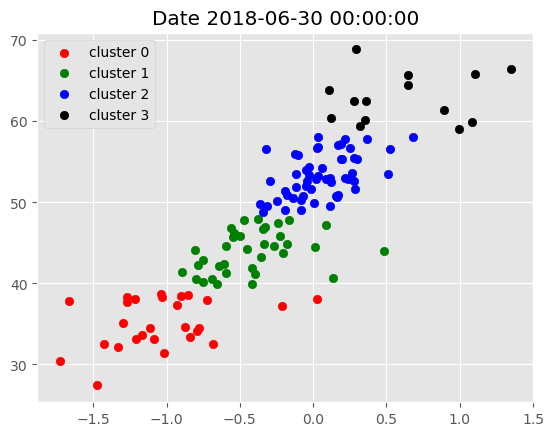

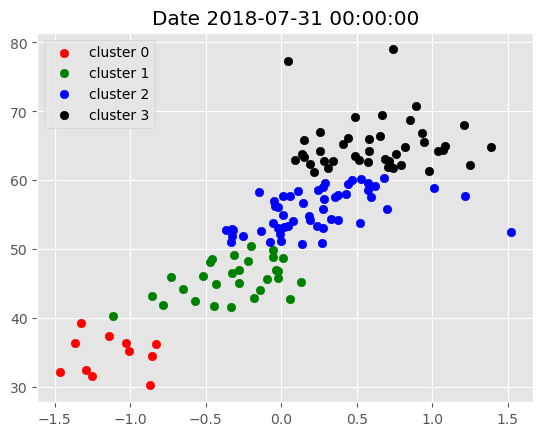

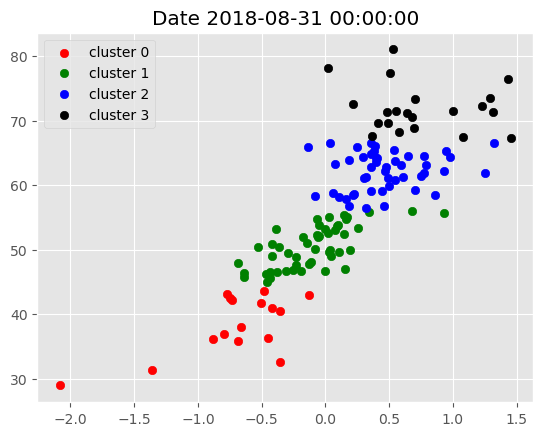

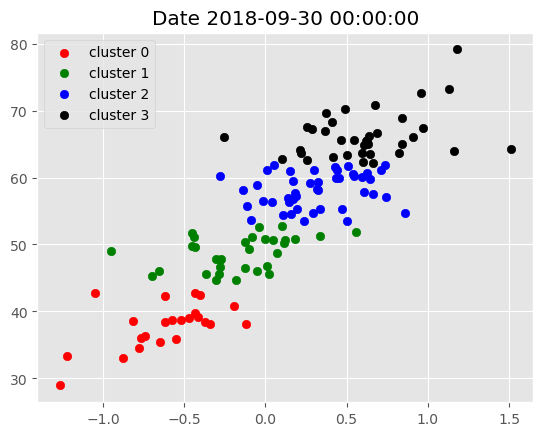

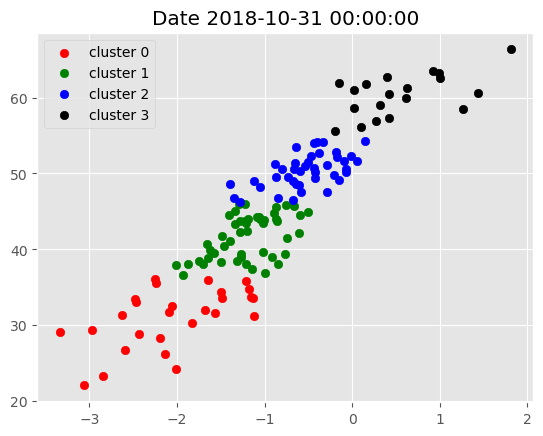

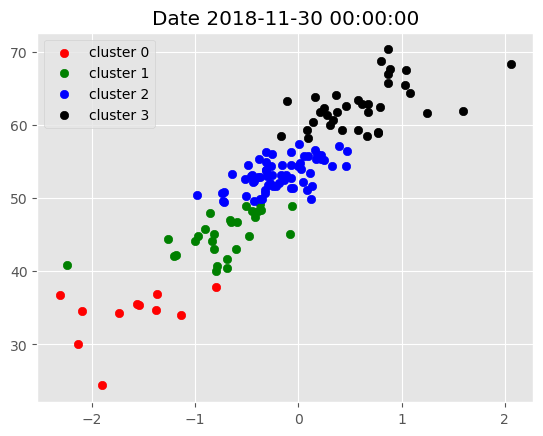

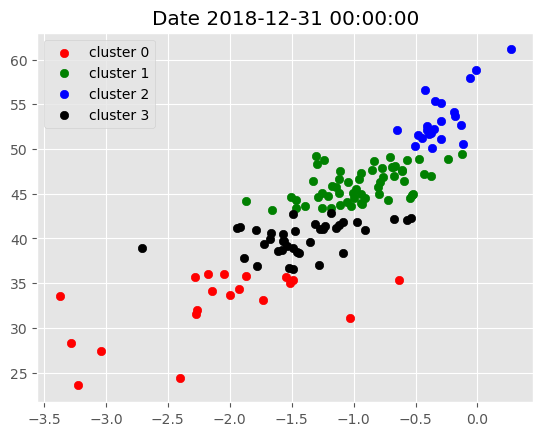

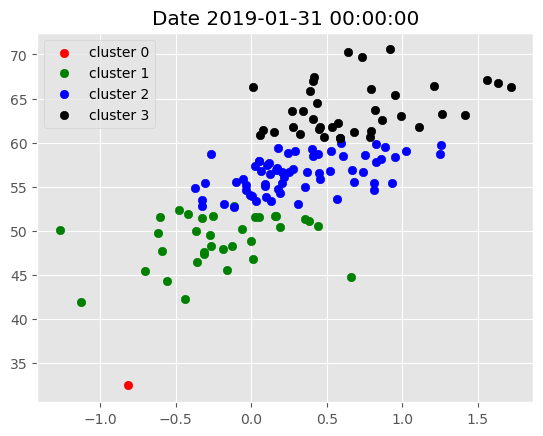

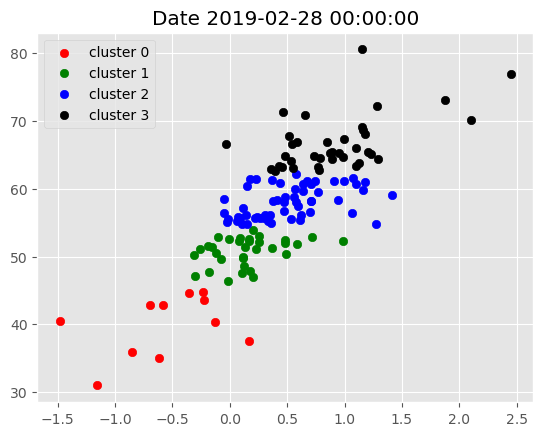

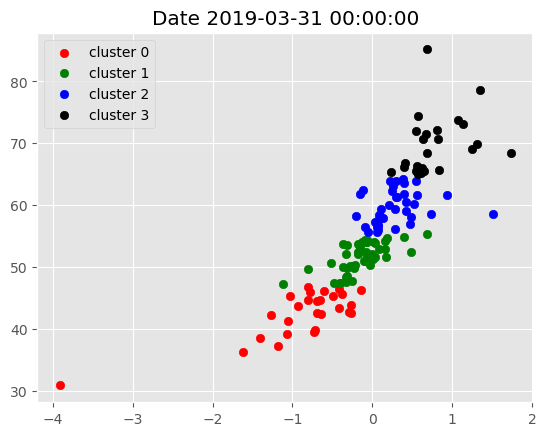

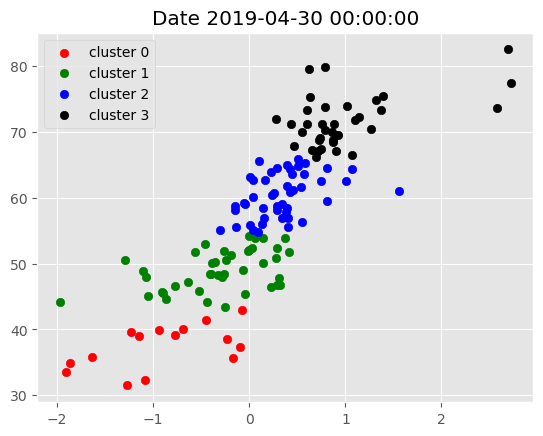

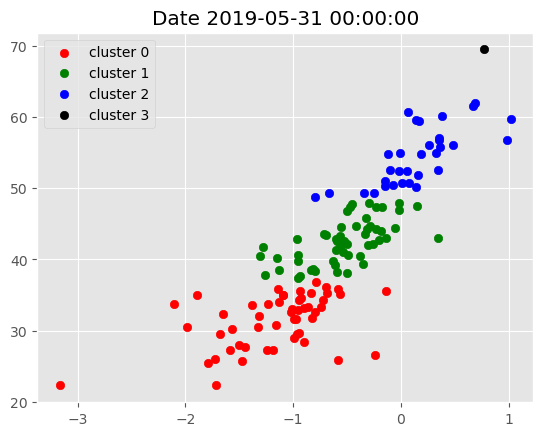

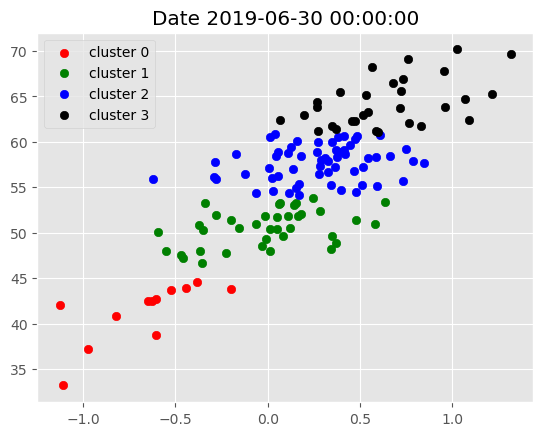

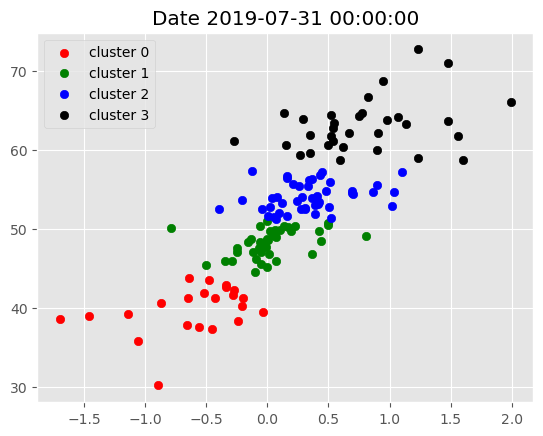

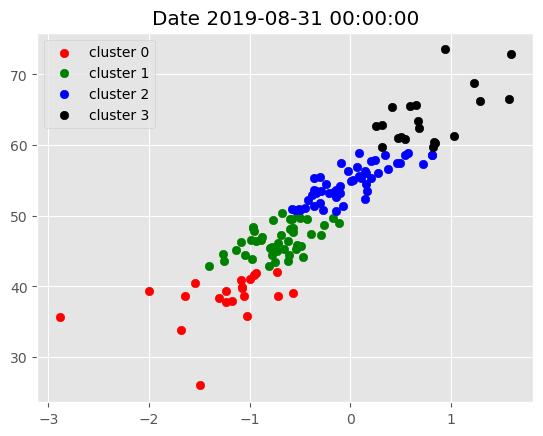

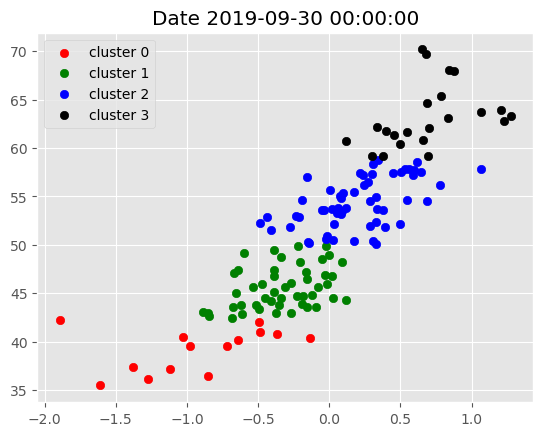

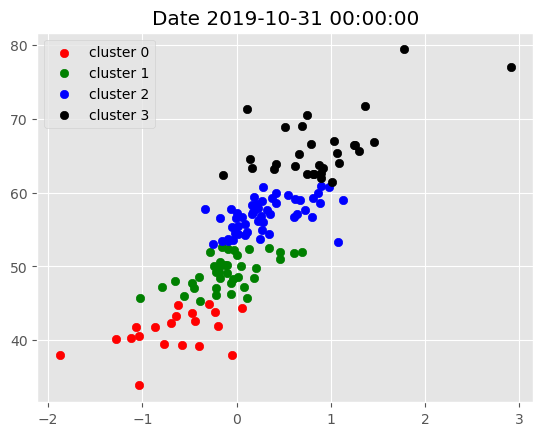

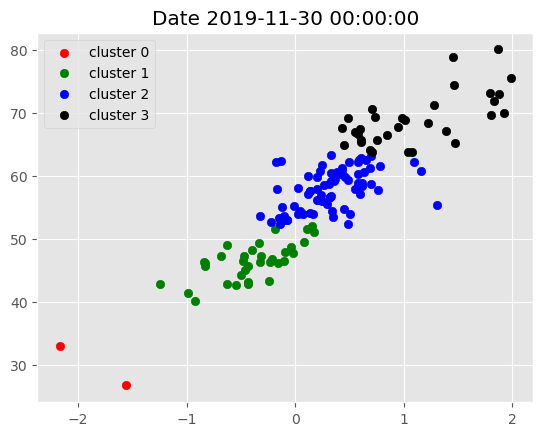

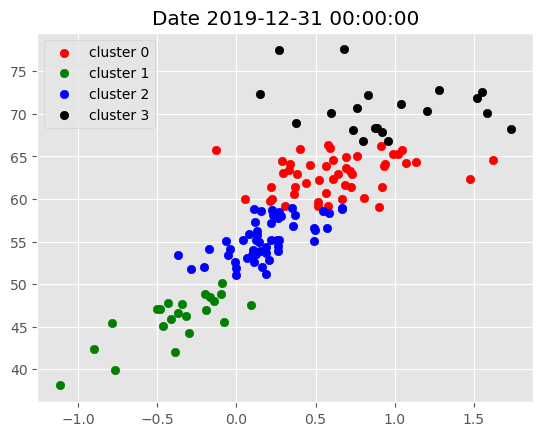

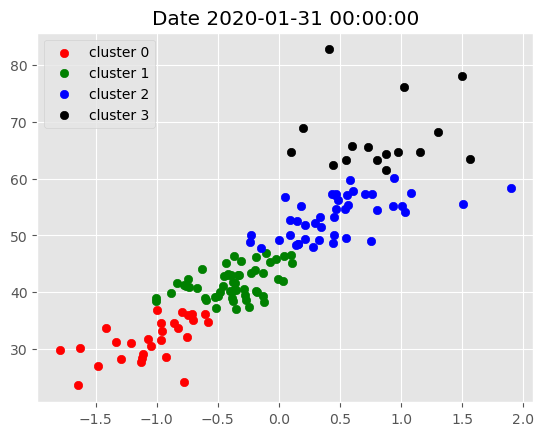

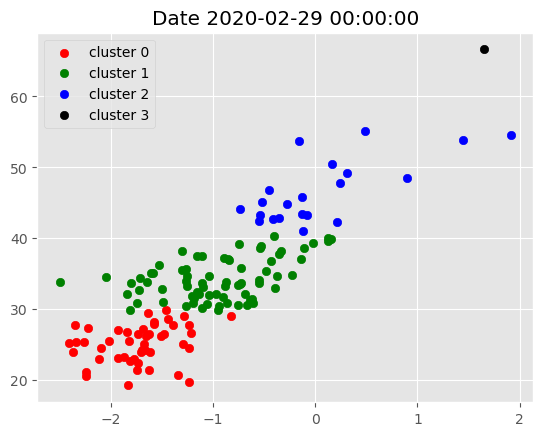

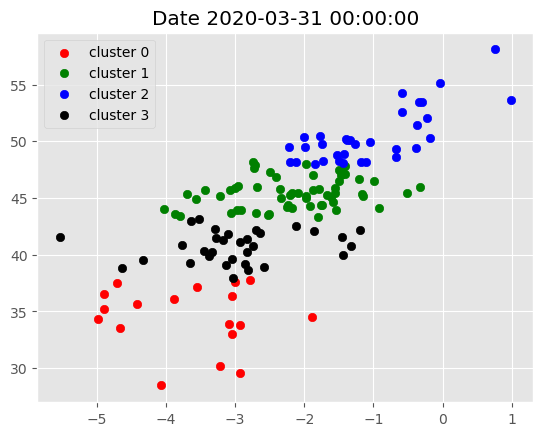

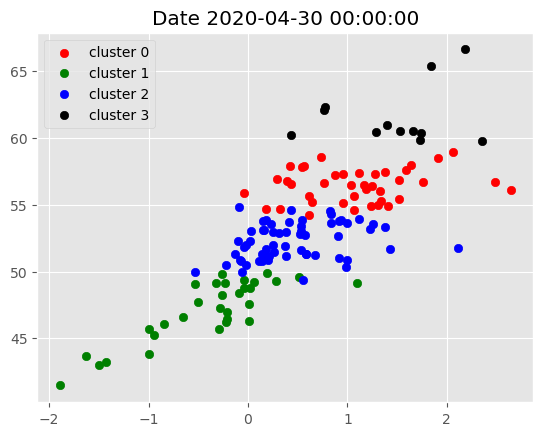

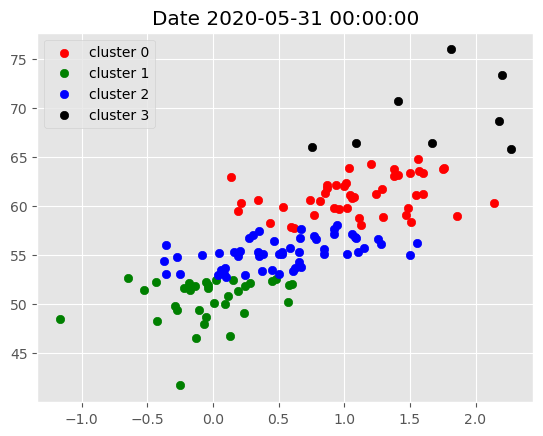

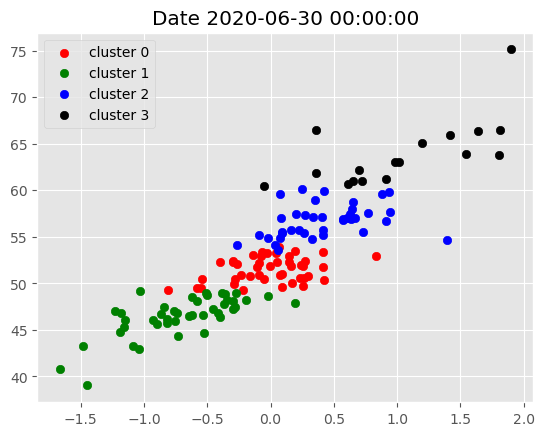

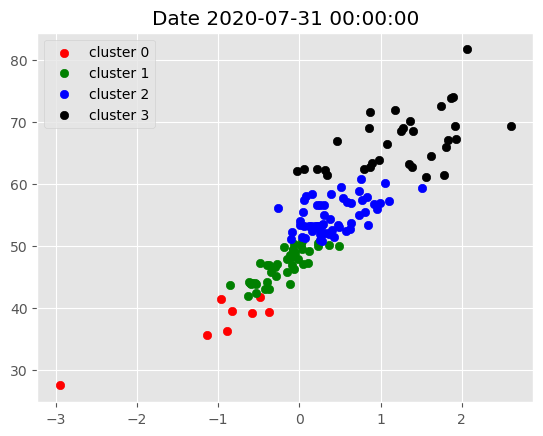

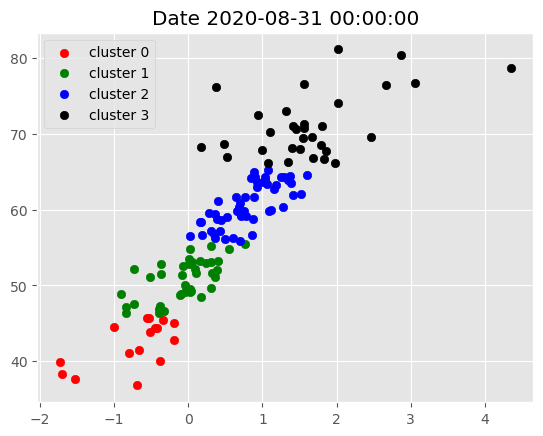

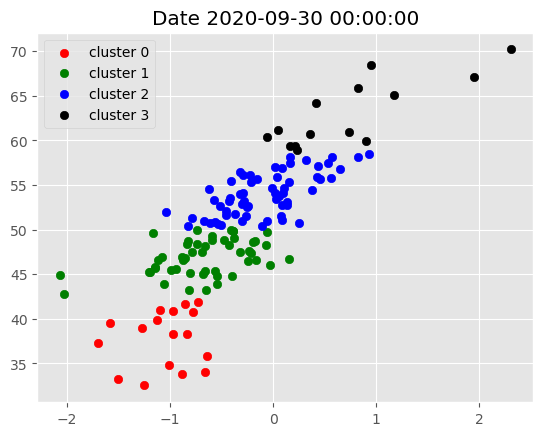

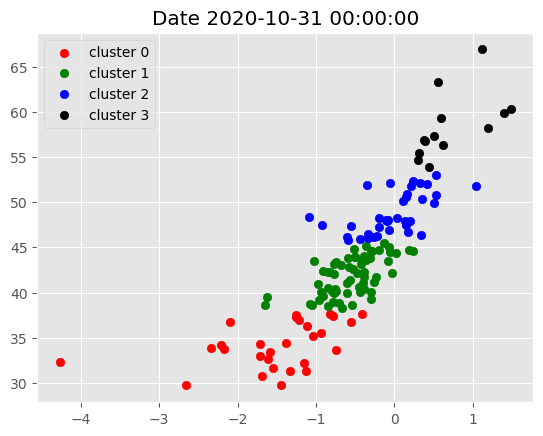

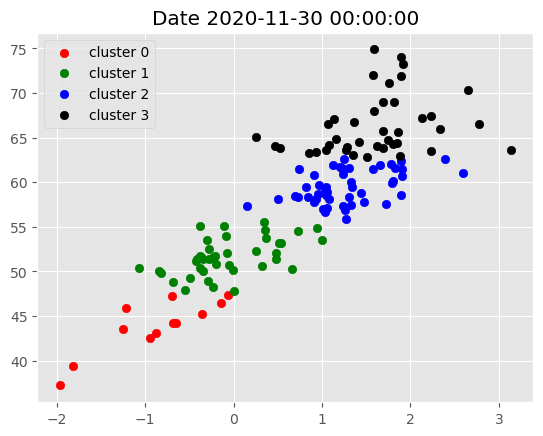

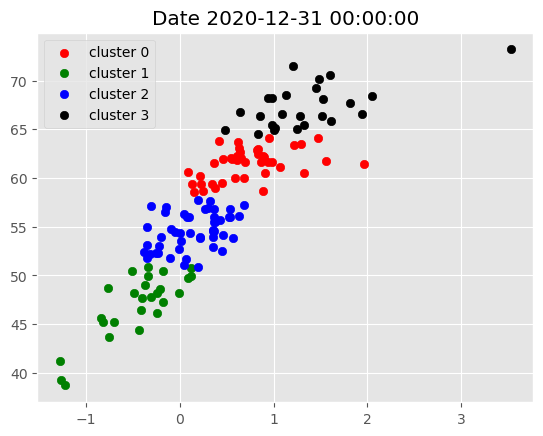

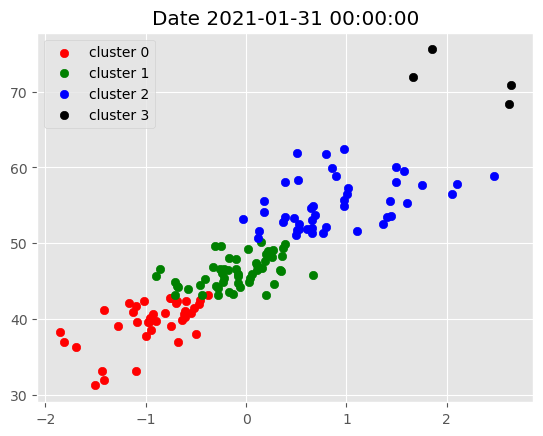

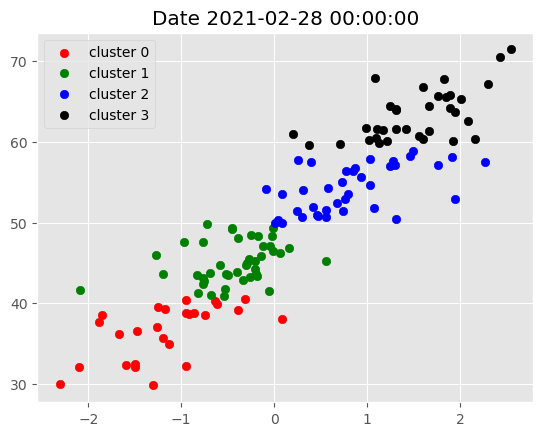

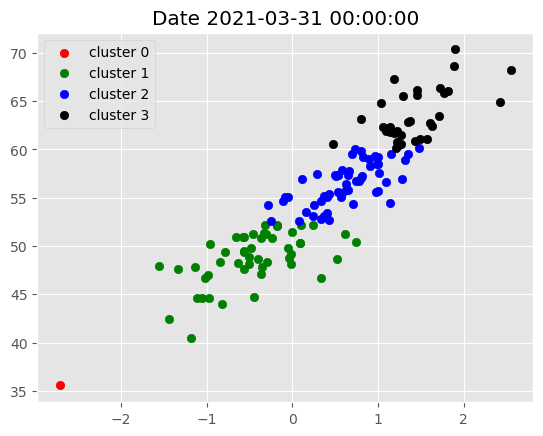

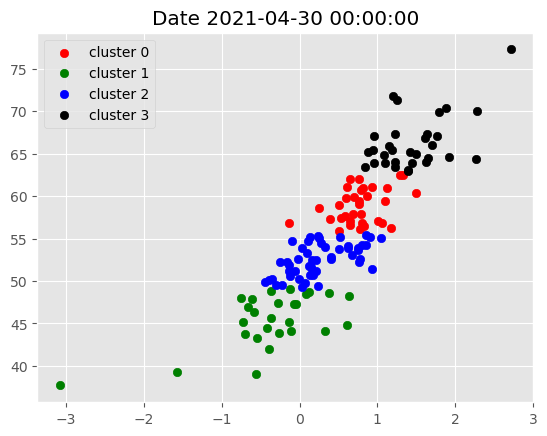

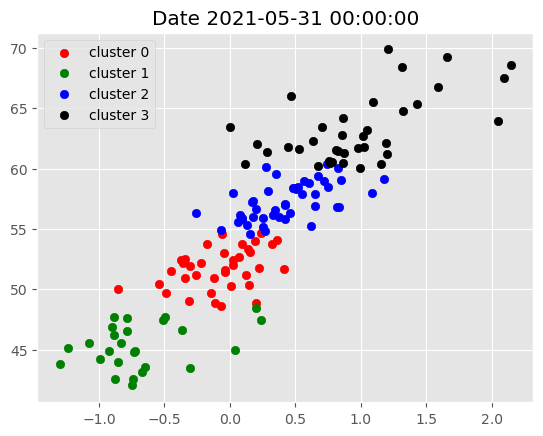

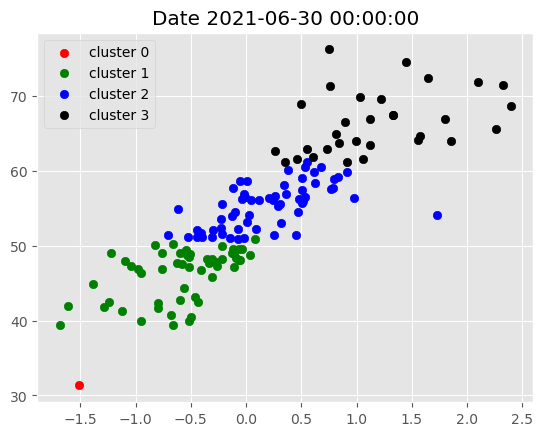

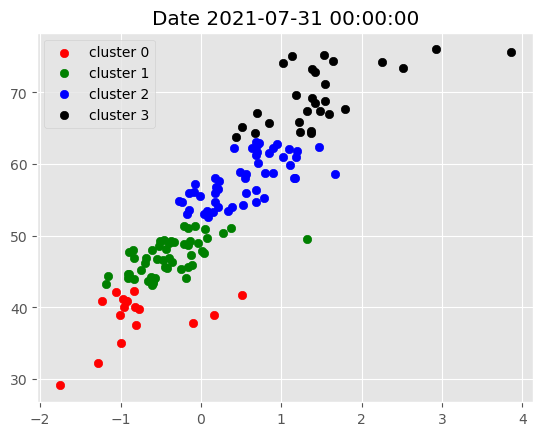

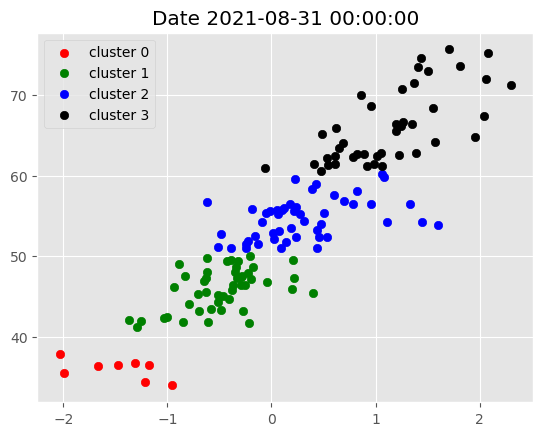

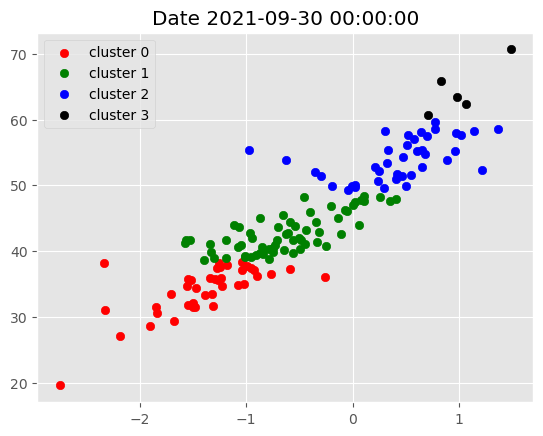

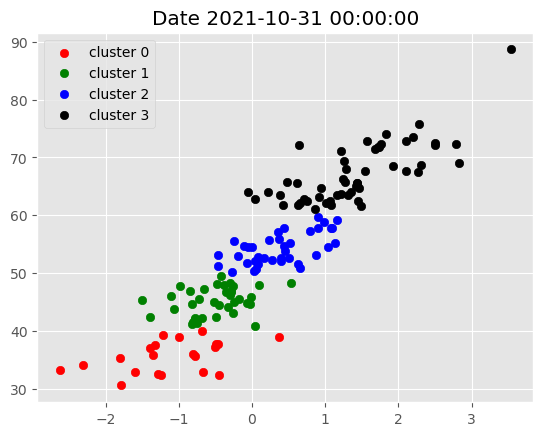

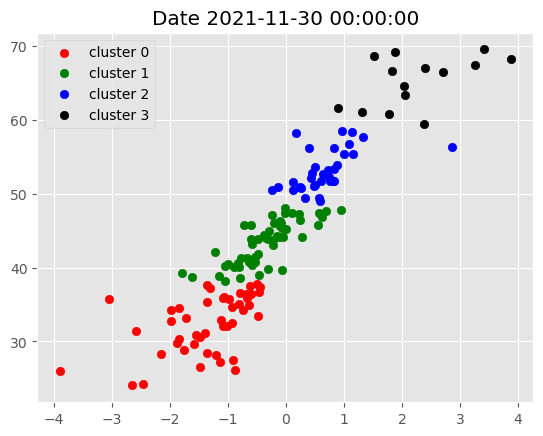

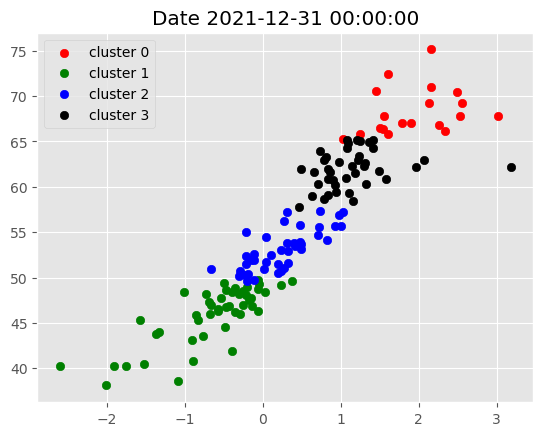

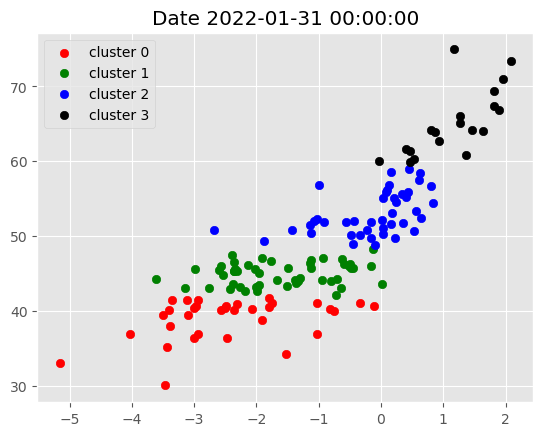

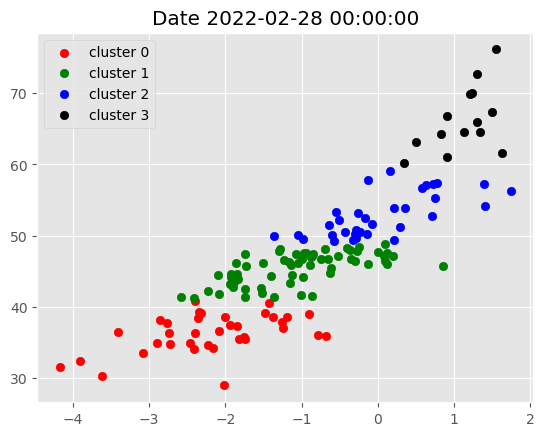

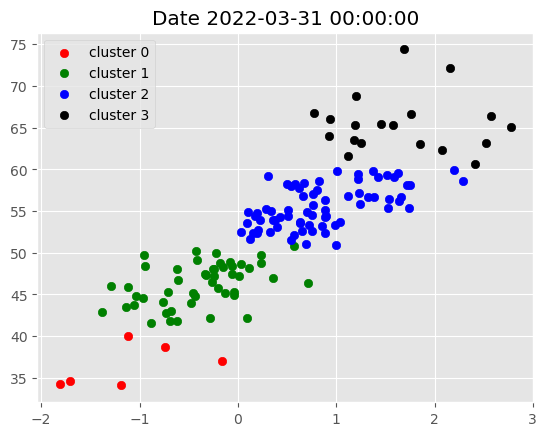

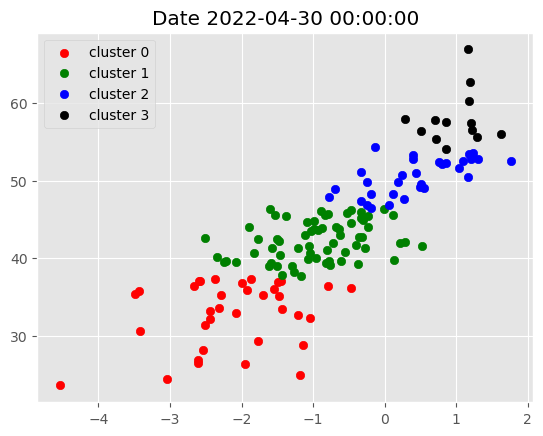

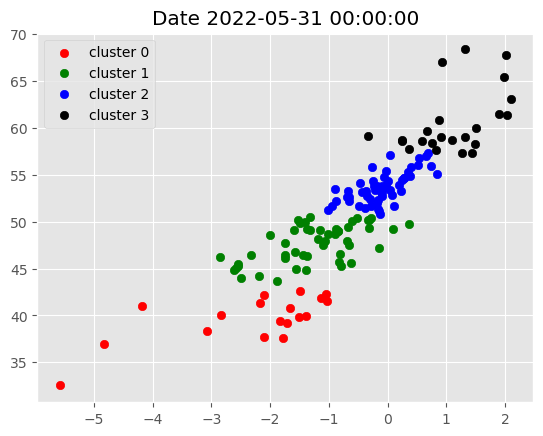

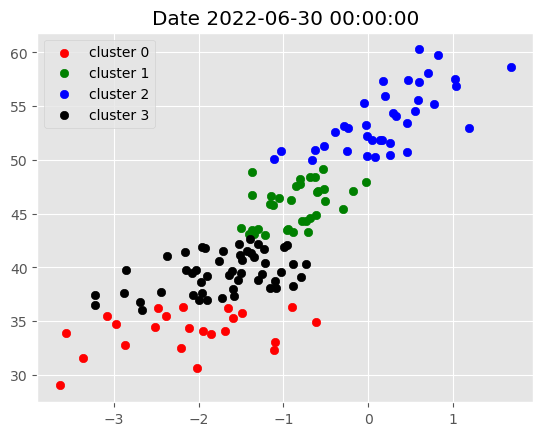

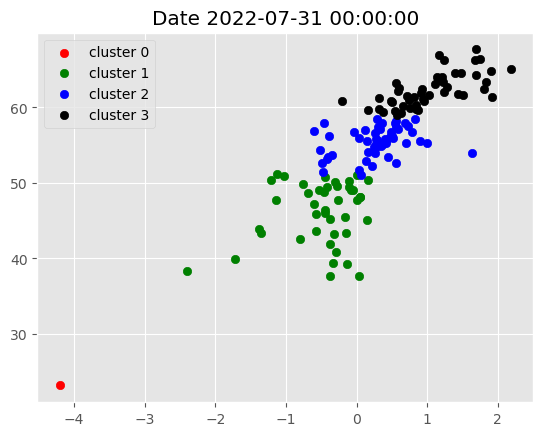

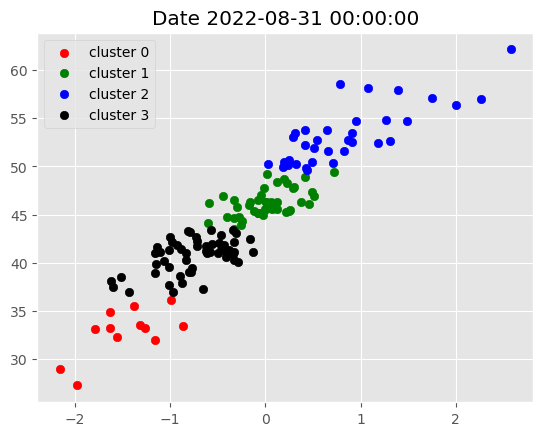

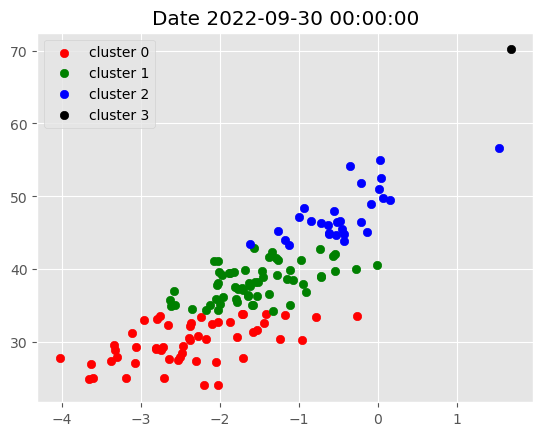

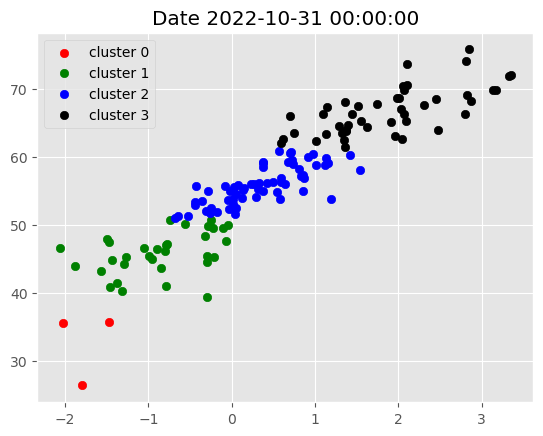

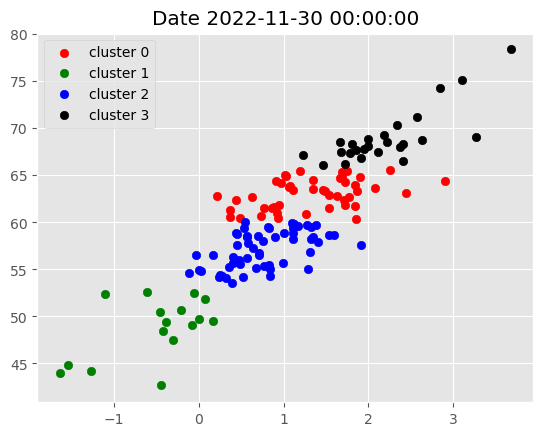

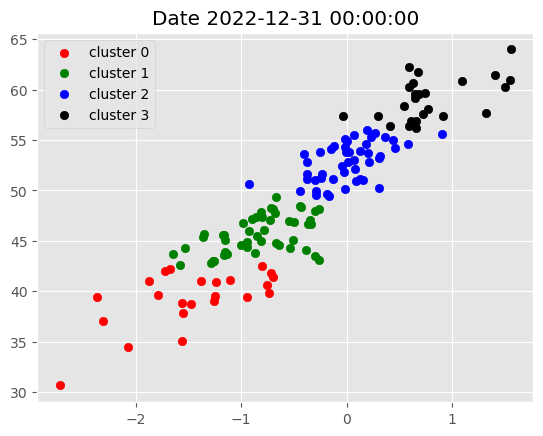

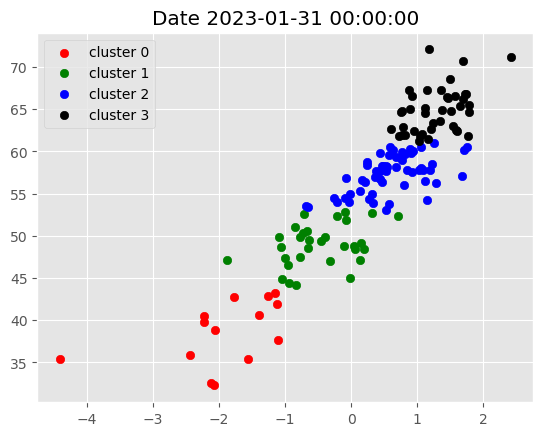

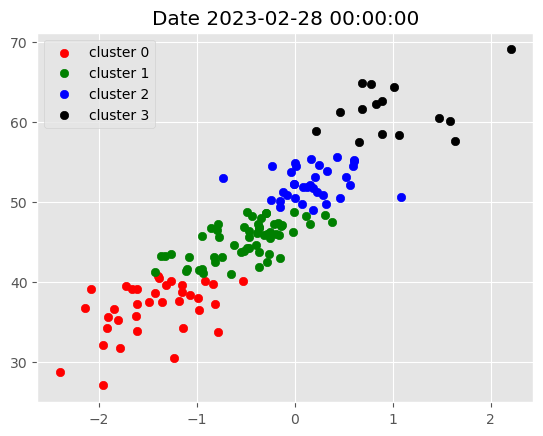

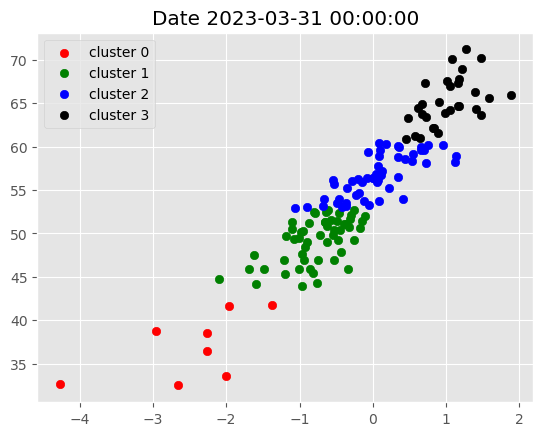

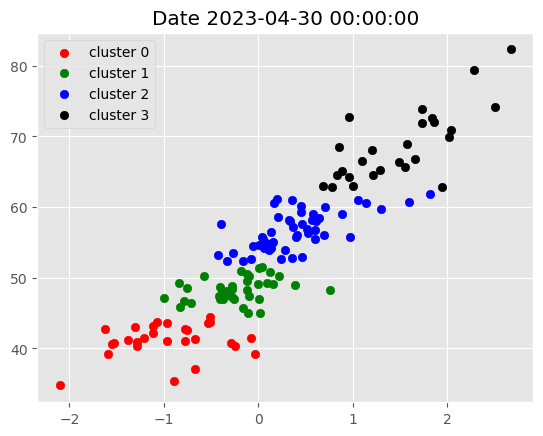

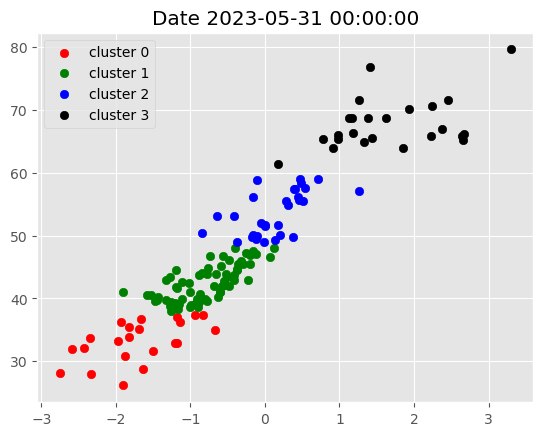

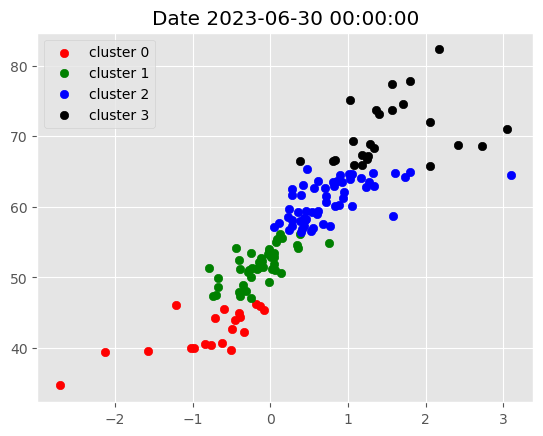

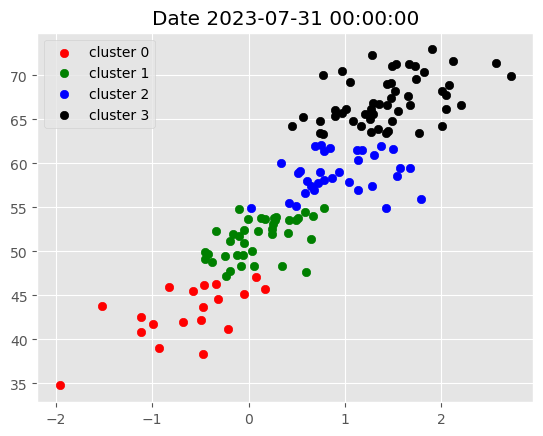

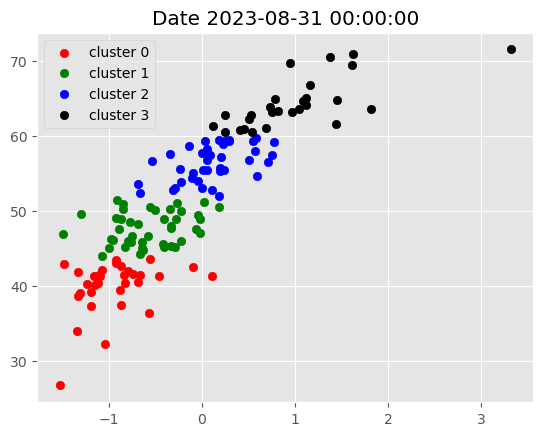

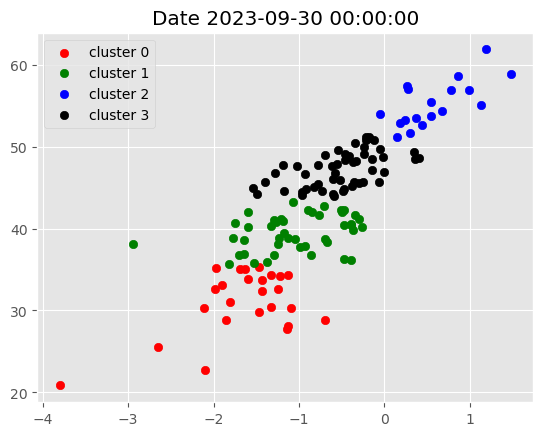

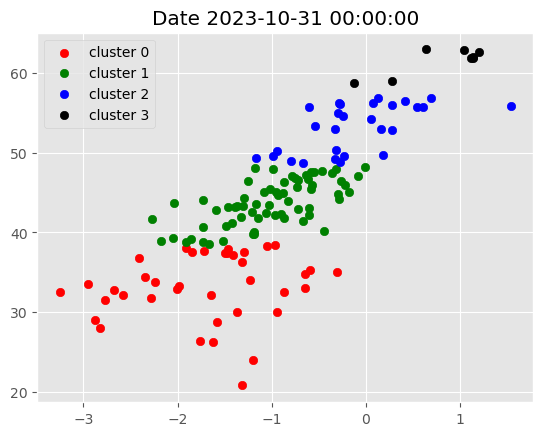

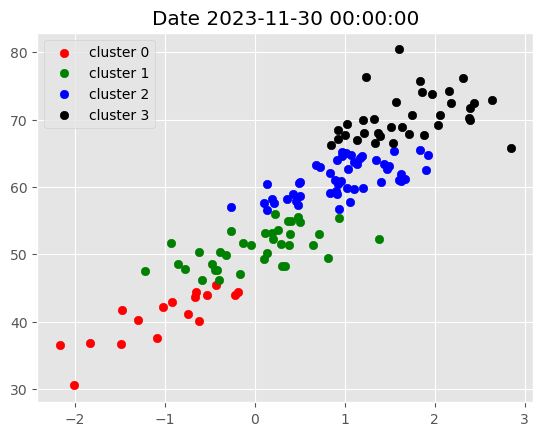

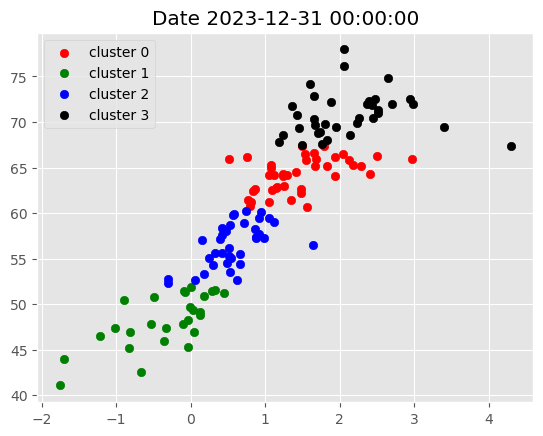

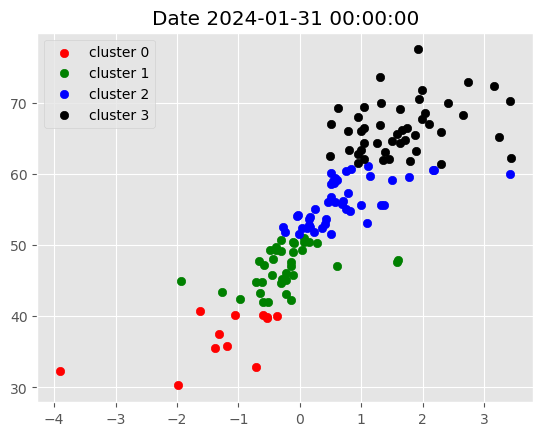

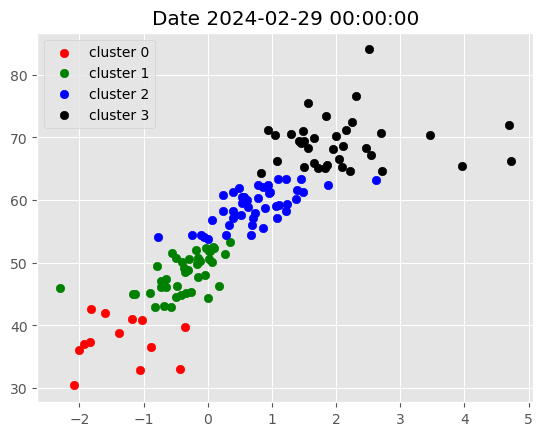

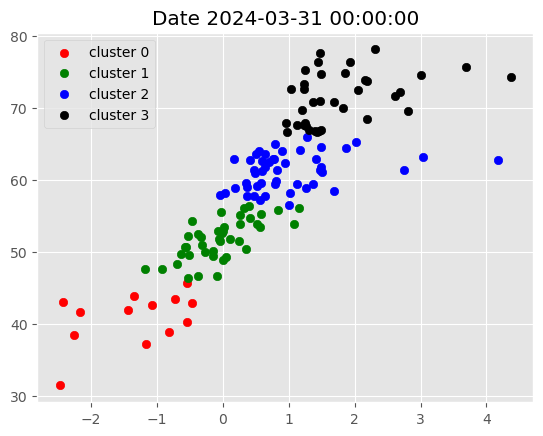

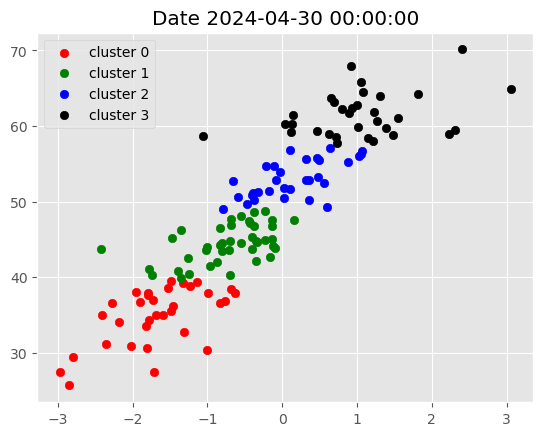

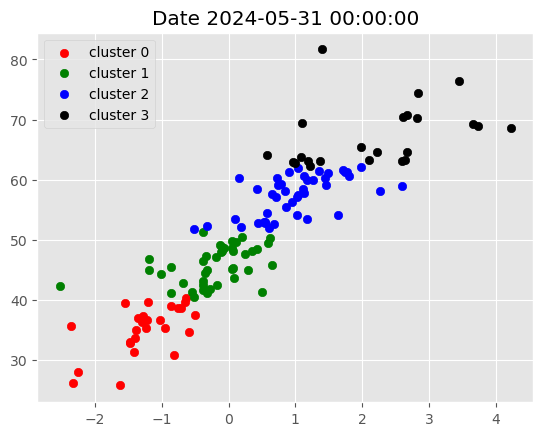

In [33]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### CLUSTER 3 Upward Momentum

In [34]:
## Based On Cluster 3, How to Form a Portfolio

In [35]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)
## Beginning of the next month

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-07-01': ['AMT',
  'BDX',
  'COST',
  'EA',
  'EOG',
  'KR',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'MDT',
  'ORLY',
  'QCOM',
  'REGN',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'V'],
 '2018-10-01': ['ABT',
  'ADP',
  'AMD',
  'AMGN',
  'AVGO',
  'CAT',
  'CI',
  'COP',
  'CSCO',
  'CVS',
  'DHR',
  'DIS',
  'ELV',
  'EOG',
  'HON',
  'ISRG',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MDT',
  'MRK',
  'ORCL',
  'ORLY',
  'PFE',
  'RTX

## Portfolio Maximization

In [178]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [179]:
## Pacakges may have version errors. Establish a New Environment can safely resolve the issue.

In [204]:
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .25),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [205]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  156 of 156 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-06-30  48.838978   33.703403   53.369370   43.018215  111.341934   
2017-07-03  48.906918   33.581722   53.303112   43.106716  111.566994   
2017-07-05  49.751320   33.719784   53.347271   43.363365  111.675034   
2017-07-06  50.518063   33.401520   52.795261   42.425293  110.675751   
2017-07-07  51.469215   33.740845   53.016064   42.867771  111.819061   
...               ...         ...         ...         ...         ...   
2024-05-23  13.820000  186.880005  158.259995  104.230003  305.929993   
2024-05-24  13.840000  189.979996  157.059998  103.949997  300.989990   
2024-05-28  13.440000  189.990005  155.339996  101.949997  297.730011   
2024-05-29  11.620000  190.289993  154.789993  100.730003  293.769989   
2024-05-30  11.440000  191.289993  156.309998  101.739998  284.799988   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-06-30  141.440002   68.284981   88.898354  100.820000  52.191296  ...   
2017-07-03  138.410004   66.801666   88.863655   99.360001  52.834087  ...   
2017-07-05  141.210007   68.232315   90.295273  102.599998  52.408337  ...   
2017-07-06  140.750000   67.872459   89.748650  102.050003  52.658783  ...   
2017-07-07  142.220001   68.873039   91.223633  103.320000  52.884171  ...   
...                ...         ...         ...         ...        ...  ...   
2024-05-23  483.309998  234.559998  251.490005  215.160004  77.580002  ...   
2024-05-24  475.429993  232.509995  248.899994  214.889999  78.029999  ...   
2024-05-28  478.429993  233.440002  243.300003  210.449997  77.360001  ...   
2024-05-29  477.600006  228.149994  240.089996  208.509995  77.570000  ...   
2024-05-30  445.869995  230.000000  240.910004  199.929993  78.250000  ...   

Price        Volume                                                           \
Ticker            V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2017-06-30  9036600  2972000  1582300  13368900   7097300  6614900  16750700   
2017-07-03  6197700  2160000   825200   9732000   2419200  4562300  11825000   
2017-07-05  9339600  3938100  1320600  14853400   6481000  5119800  14086900   
2017-07-06  8215700  3332100  1171800  16854300   6011600  4143800  14481200   
2017-07-07  6175800  5083600  1019900  12198500   6001900  3436800  11503500   
...             ...      ...      ...       ...       ...      ...       ...   
2024-05-23  6115900  2251400  1554700  14105000  16012300  5393000  13056100   
2024-05-24  4339700  1794500  1050600  10418800  10541200  2743100   9912500   
2024-05-28  6212100  1912700  1379600  15071300  20137100  4779100  11276300   
2024-05-29  5469700  3774100   967300  17652000  21387700  7524500  12835000   
2024-05-30  4903100  3970100   975400  19636500  12134300  6287400  13584800   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-06-30  20889900  1455000  14000600  
2017-07-03  14545800  2005600   8422300  
2017-07-05  18110700  1212300   9830800  
2017-07-06  18485400  1276900   9822400  
2017-07-07  15921300  1334800  10777800  
...              ...      ...       ...  
2024-05-23  16222900  1465100  15979800  
2024-05-24  11793800  1035400  12211400  
2024-05-28  13349600  1812400  13978300  
2024-05-29  11538600  2367700  13902000  
2024-05-30  13053500  1219100  14692000  

[1740 rows x 936 columns]

In [207]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

for start_date in fixed_dates.keys():
    
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        try:
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 4))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True

        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
            weights = pd.DataFrame([1/len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns=pd.Series([0])).T
            success = False

        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0) \
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                   left_index=True,
                   right_index=True) \
            .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,SPY Buy&Hold,Strategy Return
2015-01-05,-0.018225,NaN
2015-01-06,-0.009464,NaN
2015-01-07,0.012384,NaN
2015-01-08,0.017590,NaN
2015-01-09,-0.008046,NaN
...,...,...
2024-03-01,NaN,0.021959
2024-03-05,NaN,-0.006548
2024-03-06,NaN,0.007986
2024-03-07,NaN,0.010856


## Comparison & Visualization 

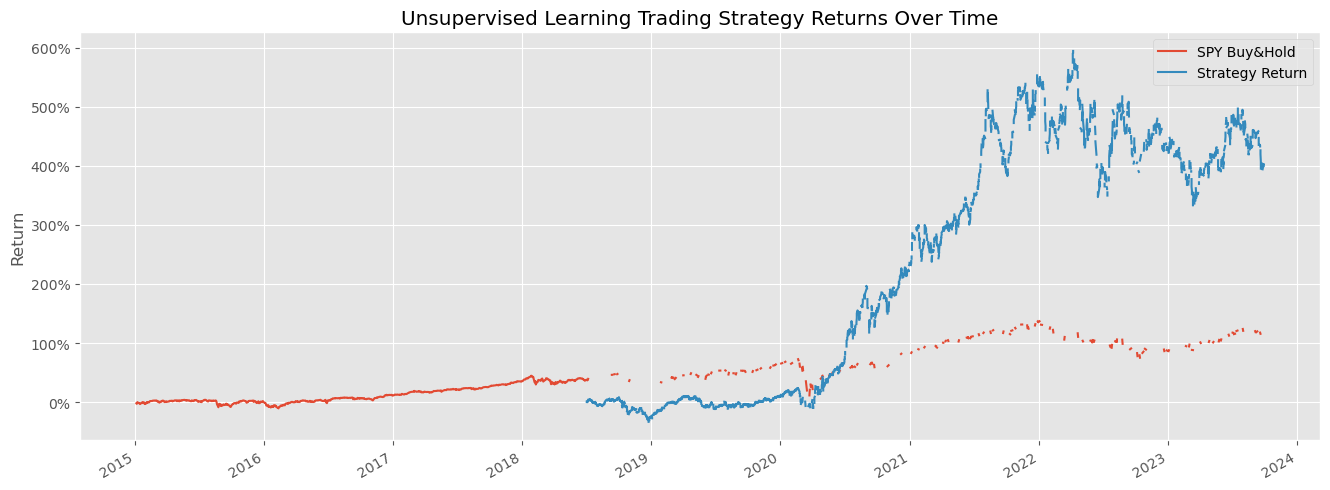

In [209]:
import matplotlib.ticker as mtick
import pandas as pd

plt.style.use('ggplot')

portfolio_df = portfolio_df.sort_index()  # Sort the DataFrame by the DatetimeIndex

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

nearest_date = pd.date_range(end='2023-09-29', periods=1, freq='D')[0]
portfolio_cumulative_return[:nearest_date].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()